In [40]:
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import pytesseract
import imutils
import cv2
import re
import requests
import numpy as np

이미지를 보기위한 함수 정의

In [42]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

처리할 텍스트 문서 이미지 파일

In [130]:
image_path = '../output/수입면장-PDF-img9.jpg'
org_image = cv2.imread(image_path)
# url = 'https://user-images.githubusercontent.com/69428232/148330274-237d9b23-4a79-4416-8ef1-bb7b2b52edc4.jpg'

# image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
# org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 

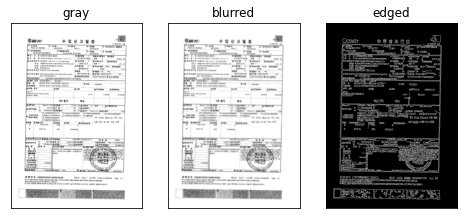

In [131]:
image = org_image.copy()
image = imutils.resize(image, width=500)
ratio = org_image.shape[1] / float(image.shape[1])

# 이미지를 grayscale로 변환하고 blur를 적용
# 모서리를 찾기위한 이미지 연산
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
edged = cv2.Canny(blurred, 75, 200)

plt_imshow(['gray', 'blurred', 'edged'], [gray, blurred, edged])

Contour란 같은 값을 가진 곳을 연결한 선이라고 생각하면 됩니다. 이미지의 외곽선을 검출하기 위해 사용합니다.

cv2.findContours(image, mode, method, contours=None, hierarchy=None, offset=None) -> contours

• image: 입력 이미지. non-zero 픽셀을 객체로 간주함
• mode: 외곽선 검출 모드. cv2.RETR_로 시작하는 상수
• method: 외곽선 근사화 방법. cv2.CHAIN_APPROX_로 시작하는 상수

In [132]:
ret, imthres = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
# contours를 찾아 크기순으로 정렬
# cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = cv2.findContours(imthres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(contours)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

In [133]:
receiptCnt = None

# 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
for c in cnts:
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.1 * peri, True)

	# contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영수증 영역으로 판단하고 break
	if len(approx) == 4:
		receiptCnt = approx
		break


# 만약 추출한 윤곽이 없을 경우 오류
if receiptCnt is None:
	raise Exception(("Could not find receipt outline."))

approx x, y, w, h 64 63 12 15
approx [[[68 63]]

 [[64 73]]

 [[71 77]]

 [[75 64]]]


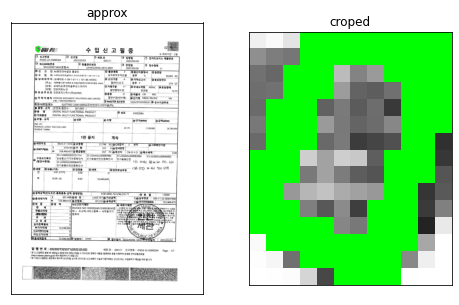

In [135]:
output = image.copy()
# cv2.drawContours(output, [receiptCnt], -1, (0, 255, 0), 2)
x, y, w, h = cv2.boundingRect(approx)
cv2.drawContours(output, [approx], -1, (0, 255, 0), 2)
print("approx x, y, w, h",x, y, w, h )

# print("x-Min =", approx[0][0])
# print("y-Min =", approx[1][1])
# print("x-Max =", approx[0][0])
# print("y-Max =", approx[0][1])
print("approx",approx )
# crop exact size -> output[y+44:y+h, x+21:x+w]
# plt_imshow("Receipt Outline", output)
# plt_imshow(['approx', 'croped'], [output, output[y+44:y+h, x+21:x+w]])
plt_imshow(['approx', 'croped'], [output, output[y:y+h, x:x+w]])

2711 [[[   1   -1   -1   -1]
  [   2    0   -1   -1]
  [   3    1   -1   -1]
  ...
  [2709 2707   -1   -1]
  [2710 2708   -1   -1]
  [  -1 2709   -1   -1]]]
3562 [[[   1   -1   -1   -1]
  [   2    0   -1   -1]
  [   3    1   -1   -1]
  ...
  [3560 3558   -1   -1]
  [3561 3559   -1   -1]
  [  -1 3560   -1   -1]]]


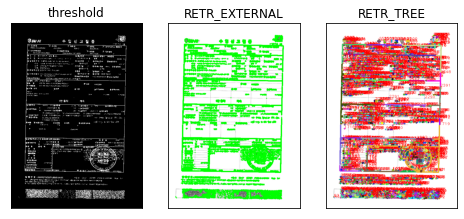

In [136]:
output0 = image.copy()
output1 = image.copy()
output2 = image.copy()
# 바이너리 이미지로 변환
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, imthres = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY_INV)

# 가장 바깥 컨투어만 수집   --- ①
contour, hierarchy = cv2.findContours(imthres, cv2.RETR_EXTERNAL, \
                                                cv2.CHAIN_APPROX_SIMPLE)
# 컨투어 갯수와 계층 트리 출력 --- ②
print(len(contour), hierarchy)

# contour = contour[1]
# # 전체 둘레의 0.05로 오차 범위 지정 ---②
# epsilon = 0.05 * cv2.arcLength(contour, True)
# # 근사 컨투어 계산 ---③
# approx = cv2.approxPolyDP(contour, epsilon, True)


# 모든 컨투어를 트리 계층 으로 수집 ---③
contour2, hierarchy = cv2.findContours(imthres, cv2.RETR_TREE, \
                                            cv2.CHAIN_APPROX_SIMPLE)
# 컨투어 갯수와 계층 트리 출력 ---④
print(len(contour2), hierarchy)

# 가장 바깥 컨투어만 그리기 ---⑤
cv2.drawContours(output0, contour, -1, (0,255,0), 3)

# 모든 컨투어 그리기 ---⑥
for idx, cont in enumerate(contour2): 
    # 랜덤한 컬러 추출 ---⑦
    color = [int(i) for i in np.random.randint(0,255, 3)]
    # 컨투어 인덱스 마다 랜덤한 색상으로 그리기 ---⑧
    cv2.drawContours(output1, contour2, idx, color, 3)
    # 컨투어 첫 좌표에 인덱스 숫자 표시 ---⑨
    cv2.putText(output1, str(idx), tuple(cont[0][0]), cv2.FONT_HERSHEY_PLAIN, \
                                                            1, (0,0,255))

plt_imshow(['threshold', 'RETR_EXTERNAL', 'RETR_TREE'], [imthres, output0, output1])

0 -> 49320 ( 156 391 274 180 )
1 -> 28520 ( 56 158 124 230 )
2 -> 15096 ( 289 87 148 102 )
3 -> 13612 ( 113 487 166 82 )
4 -> 6570 ( 61 84 90 73 )


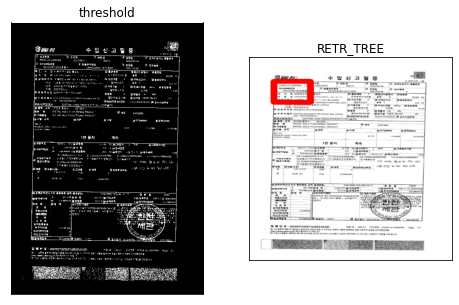

In [137]:
# binarize
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# find contours
ctrs, hier = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# find rect and area - and create items [contour, rect, area] - but sorting by area gives wrong results
#items = [[ctr, cv2.boundingRect(ctr), cv2.contourArea(ctr)] for ctr in ctrs]

# find rect - and create items [contour, rect]
items = [[ctr, cv2.boundingRect(ctr)] for ctr in ctrs]

# find rect's size and create items [contour, rect, size]
items = [[ctr, rect, rect[2]*rect[3]] for ctr, rect in items]

# sort by size 
items = sorted(items, key=lambda x: x[2], reverse=True)

for index, item in enumerate(items[:5]):

    contour = item[0]
    x, y, w, h = item[1]
    size = item[2]

    print(index, '->', size, '(', x, y, w, h, ')')

    img_copy = image.copy()
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 0, 255), 15)
    resize_img = cv2.resize(img_copy, (512,512))

    # cv2.imshow('frame', resize_img)
    # cv2.waitKey(0)

plt_imshow(['threshold', 'RETR_TREE'], [thresh, resize_img])

# --- save image ---

# item = items[2]

# contour = item[0]
# x, y, w, h = item[1]
# size = item[2]

# img = img[y:y+h, x:x+w]

contour index== 0
Find rectangle contour


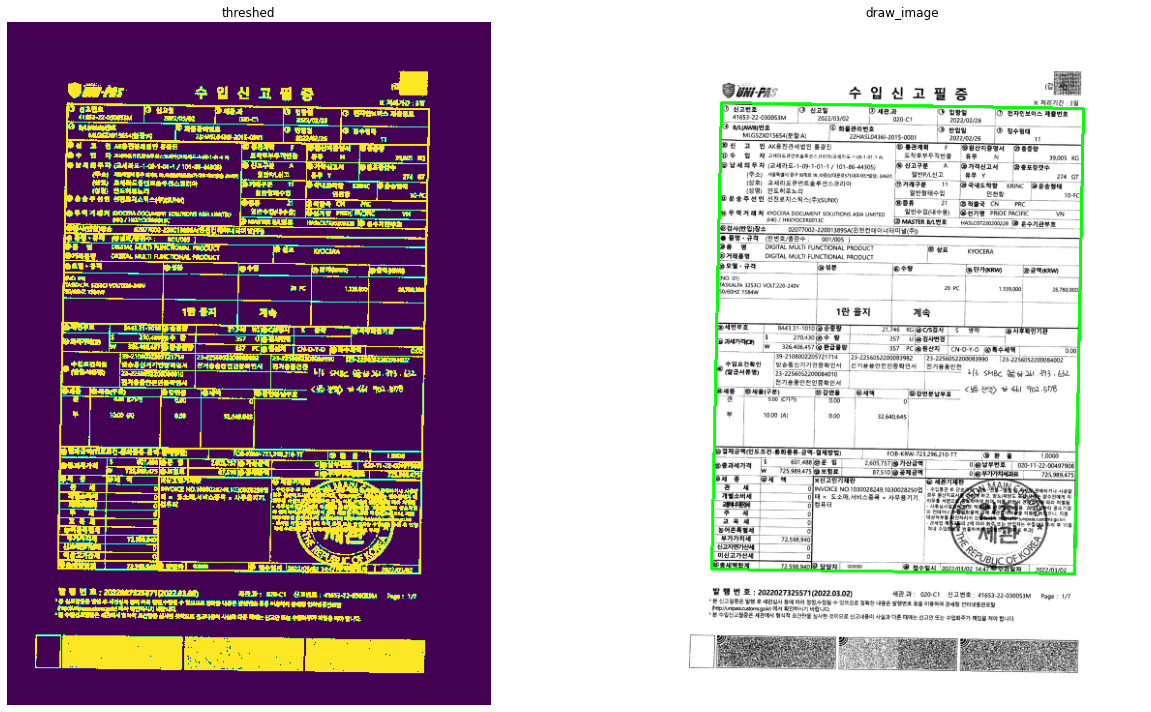

In [140]:
def edge_detection(image_bgr):
    """
    흰색바탕의 A4크기의 배경에서 운전면허증 외곽 인식
    Input : image --> 이미지(bgr image)
    return : rot_rect --> 4개의 사각형 좌표와 기운 정도를 나타내는 각도 정보
    """

    ## (1) 이미지 이진화, 흰색부분을 검은색으로 면허증 부분은 흰색으로
    draw_image = image_bgr.copy()
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    binary = cv2.bitwise_not(gray)
    th, threshed = cv2.threshold(binary, 10, 255, cv2.THRESH_BINARY)

    ## (2) Find the max-area contour
    (contours,_) = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 면적이 큰거 5개만 추출
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:2]

    screenCnt = None
    for index,c in enumerate(contours):
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            print("contour index==", index)
            screenCnt = approx
            ## This will extract the rotated rect from the contour
            rot_rect = cv2.minAreaRect(screenCnt)
            break

    if screenCnt is None:
        print("Do not find rectangle contour")
        rot_rect = None
    else:
        # show the contour (outline) of the piece of paper
        print ("Find rectangle contour")
        cv2.drawContours(draw_image, [screenCnt], -1, (0, 255, 0), 2)
   

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(threshed)
    plt.title("threshed")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(draw_image)
    plt.title("draw_image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return rot_rect


rot_rect = edge_detection(image)
# plt_imshow("문서외곽선인식", edge_detection(image))

/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50808 (\N{HANGUL SYLLABLE OE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44285 (\N{HANGUL SYLLABLE GWAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) mis

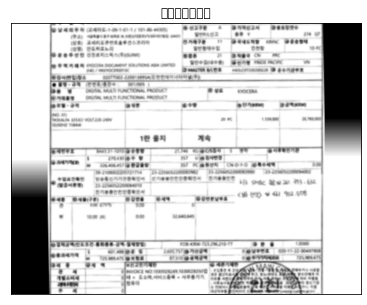

In [141]:
# Crop Rectangle returned by minAreaRect OpenCV [Python]
# https://stackoverflow.com/questions/37177811/crop-rectangle-returned-by-minarearect-opencv-python
def get_warpAffine(rect, img):
    """
    Input : rect(cv2.minAreaRect()), img
    rect : 4개의 사각형 좌표와 기운 정도를 나타내는 각도 정보
    img : 칼라 이미지(Color image)
    return : croppedRotated
    사각형 좌표로 잘라내고 기운 각도가 없는 수평정렬된 이미지
    Procedure :
    1. 좌표와 이미지를 입력받아 좌표와 각도 분리
    2. 좌표내의 이미지를 수평이 되도록 변환
    3. 좌표의 크기대로 이미지를 자르고 리턴한다.
    """
    box = cv2.boxPoints(rect) 
    box = np.int0(box)

    W = rect[1][0]
    H = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    angle = rect[2]
    if angle < -45:
        angle += 90

    # Center of rectangle in source image
    center = ((x1+x2)/2,(y1+y2)/2)
    # Size of the upright rectangle bounding the rotated rectangle
    size = (x2-x1, y2-y1)
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    # Cropped upright rectangle
    cropped = cv2.getRectSubPix(img, size, center)
    cropped = cv2.warpAffine(cropped, M, size)
    croppedW = H if H > W else W
    croppedH = H if H < W else W
    # Final cropped & rotated rectangle
    croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW),int(croppedH)), (size[0]/2, size[1]/2))
    
    return croppedRotated


plt_imshow("문서외곽선인식", get_warpAffine(rot_rect, image))